# **CMPE 258 Assignment 1 - Part 2**
TensorFlow, Keras and deep learning
Arpitha Gurumurthy </br>
Reference: https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist#0

# **NOTE 1:**
There are 50,000 training digits in this dataset. They feed a "batch" of them of size 128 into the training loop at each iteration so the system will have seen all the training digits once after 391 iterations. This is called "epoch".

There are also 10,000 separate "validation" digits for testing the performance of the model.

### Parameters
The batch size, number of training epochs and location of the data files is defined here. Data files are hosted in a Google Cloud Storage (GCS) bucket which is why their address starts with gs://

In [1]:
BATCH_SIZE = 128
EPOCHS = 10

##codelab uses the MNIST dataset, a collection of 60,000 labeled digits 
training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

### Imports
All the necessary Python libraries are imported here, including TensorFlow and also matplotlib for visualizations.

In [2]:
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [3]:
#@title visualization utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break
    
  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

### tf.data.Dataset: parse files and prepare training and validation datasets
This cell uses the tf.data.Dataset API to load the MNIST dataset form the data files.

**SMALL NOTE**: </br>
.cache caches the dataset in RAM. This is a tiny dataset so it will work. .shuffle shuffles it with a buffer of 5000 elements. It is important that training data are well shuffled. .repeat loops the dataset. We will be training on it multiple times (multiple epochs). .batch pulls multiple images and labels together into a mini-batch. Finally, .prefetch can use the CPU to prepare the next batch while the current batch is being trained on the GPU.


In [4]:
AUTO = tf.data.experimental.AUTOTUNE

def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label

def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    #We apply read_image function to the dataset using .map and obtain a dataset of images
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(AUTO)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# For TPU, we will need a function that returns the dataset
training_input_fn = lambda: get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_images_file, validation_labels_file)

### Let's have a look at the data

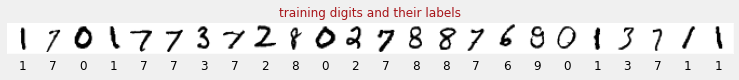

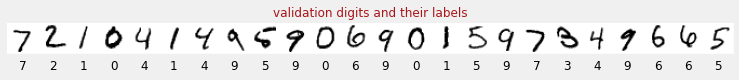

In [5]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

### Keras model
Initially, it's a single dense layer. It has 10 neurons because we are classifying handwritten digits into 10 classes. It uses "softmax" activation because it is the last layer in a classifier.

A Keras model also needs to know the shape of its inputs. tf.keras.layers.Input can be used to define it. Here, input vectors are flat vectors of pixel values of length 28*28.

In [6]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


### Train and validate the model
This is where the training happens, by calling model.fit and passing in both the training and validation datasets. By default, Keras runs a round of validation at the end of each epoch.

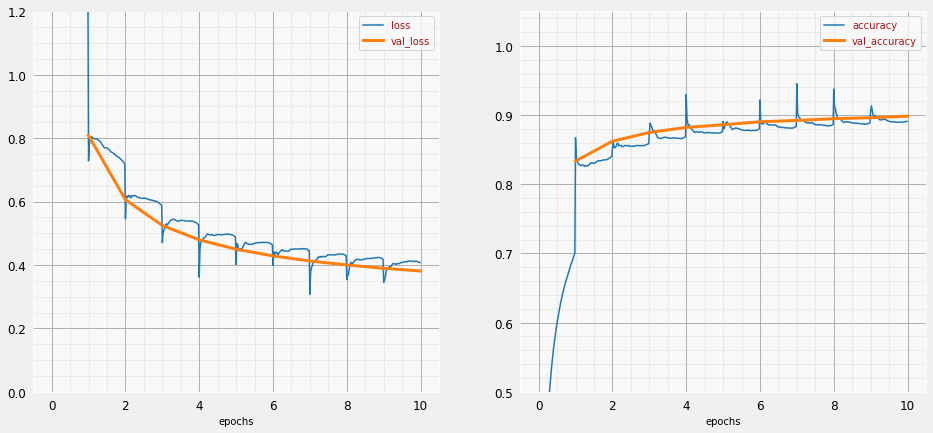

In [7]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])

In the above training graph, the accuracy on the right needs to be maximum and the loss on the left should be minimized.

### Visualize predictions
Once the model is trained, we can get predictions from it by calling model.predict()



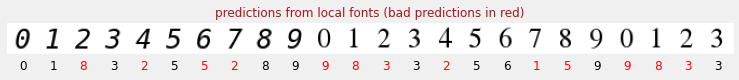

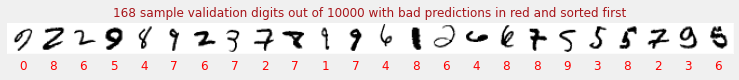

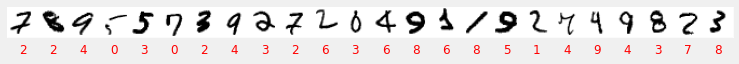

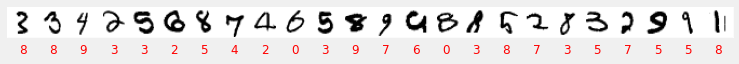

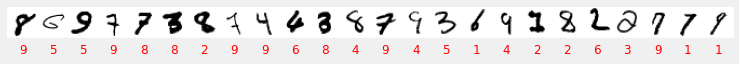

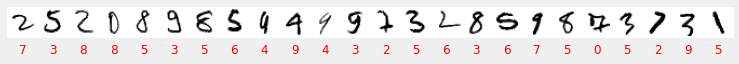

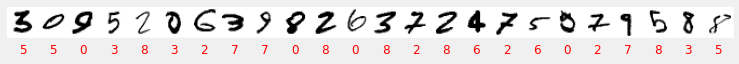

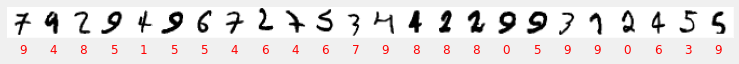

In [8]:
# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

In the above prediction, few digits rendered from local fonts (first line) are identified correctly and then the rest are from the validation dataset. Initially the model accuracy is around 90%.

# **NOTE 2**
Data is stored in matrices. A 28x28 pixel grayscale image fits into a 28x28 two-dimensional matrix. But for a color image, we need more dimensions. There are 3 color values per pixel (Red, Green, Blue), so a three-dimensional table will be needed with dimensions [28, 28, 3]. And to store a batch of 128 color images, a four-dimensional table is needed with dimensions [128, 28, 28, 3].
These multi-dimensional tables are called "**tensors**" and the list of their dimensions is their "shape".


A **neural network classifier** is made of several layers of neurons. For image classification these can be dense or, more frequently, convolutional layers. They are typically activated with the relu activation function. The last layer uses as many neurons as there are classes and is activated with softmax. For classification, cross-entropy is the most commonly used loss function, comparing the one-hot encoded labels (i.e. correct answers) with probabilities predicted by the neural network. To minimize the loss, it is best to choose an optimizer with momentum, for example Adam and train on batches of training images and labels.




# **ADDING LAYERS:**
For models built as a sequence of layers Keras offers the Sequential API. An image classifier using three dense layers after modifying the above inital model:


In [19]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='sigmoid'),
      tf.keras.layers.Dense(60, activation='sigmoid'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 200)               157000    
_________________________________________________________________
dense_20 (Dense)             (None, 60)                12060     
_________________________________________________________________
dense_21 (Dense)             (None, 10)                610       
Total params: 169,670
Trainable params: 169,670
Non-trainable params: 0
_________________________________________________________________


The solution is to add some momentum to the optimization algorithm so that it can sail past saddle points without stopping.

The TensorFlow library provides a whole range of optimizers, starting with basic gradient descent tf.keras.optimizers.SGD, which now has an optional momentum parameter. More advanced popular optimizers that have a built-in momentum are tf.keras.optimizers.RMSprop or tf.keras.optimizers.Adam.



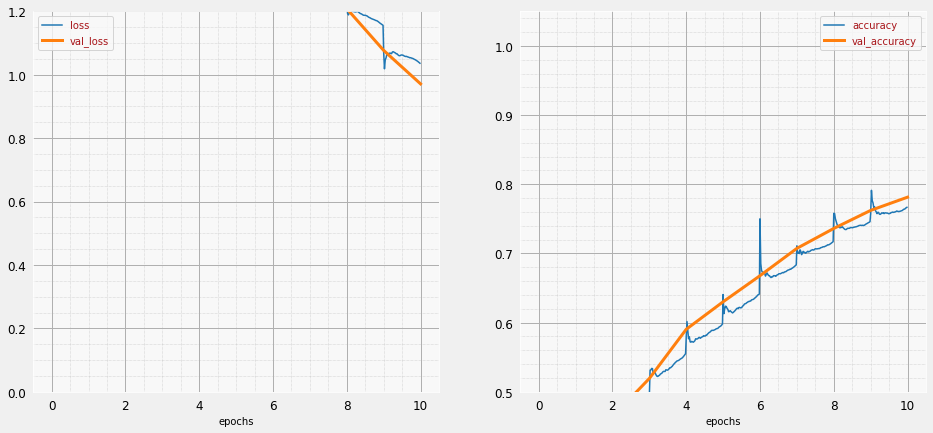

In [20]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])

The accuracy is down to 77% after adding the layers and the loss seems to have increased as well.

# **RELU Activation with adam optimizer**

In [21]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 200)               157000    
_________________________________________________________________
dense_23 (Dense)             (None, 60)                12060     
_________________________________________________________________
dense_24 (Dense)             (None, 10)                610       
Total params: 169,670
Trainable params: 169,670
Non-trainable params: 0
_________________________________________________________________


With the sigmoid function, when it gets flat the derivative gets close to 0. If there are many layers, the training becomes slower and slower. The relu has a derivative of 1, at least on its right side. With RELU activation, even if the gradients coming from some neurons can be zero, there will always be others giving a clear non-zero gradient and training can continue at a good pace.

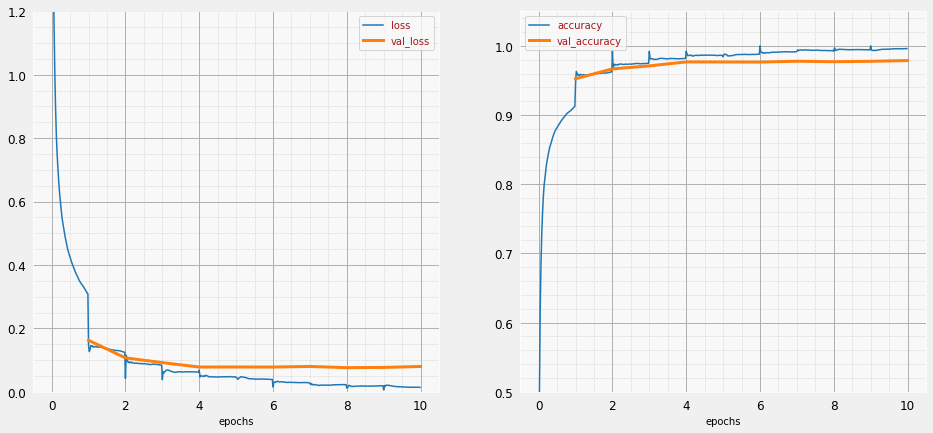

In [22]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])

# **Learning rate decay**

The accuracy in the above graph seems to be around 97% and loss is also minimizing at this point.

In [31]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=5)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 200)               157000    
_________________________________________________________________
dense_38 (Dense)             (None, 60)                12060     
_________________________________________________________________
dense_39 (Dense)             (None, 10)                610       
Total params: 169,670
Trainable params: 169,670
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


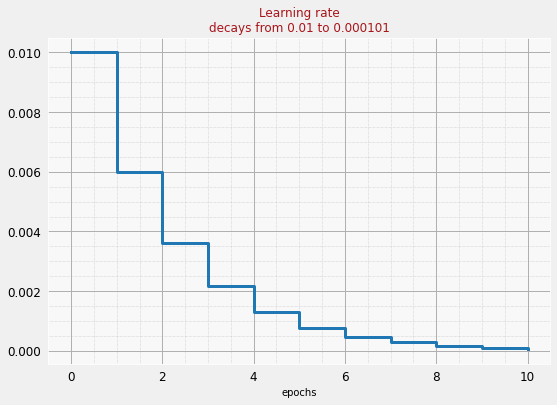

In [32]:
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

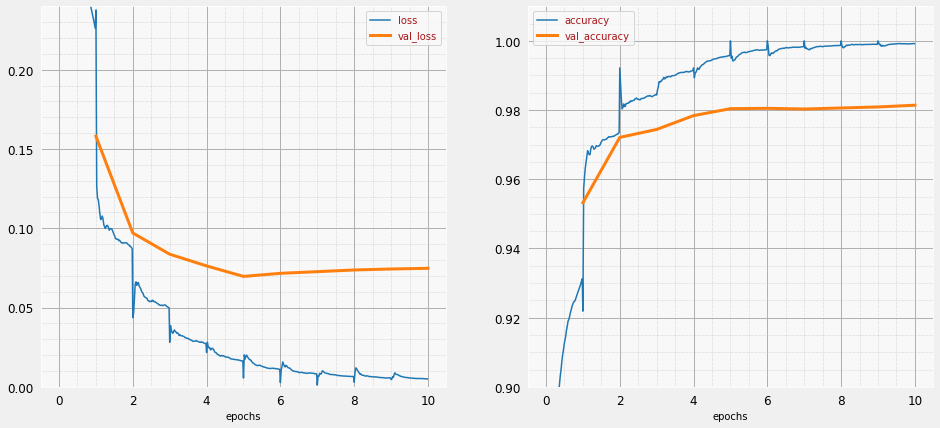

In [33]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training, lr_decay_callback])

Most of the noise is gone and the test accuracy is now above 98% in a sustained way.

# **Dropout and overfitting**

In [34]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=10)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 200)               157000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 60)                6060      
_________________________________________________________________
dropout_8 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 10)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


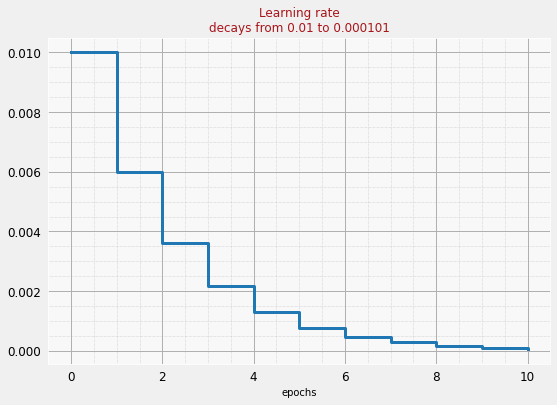

In [35]:
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

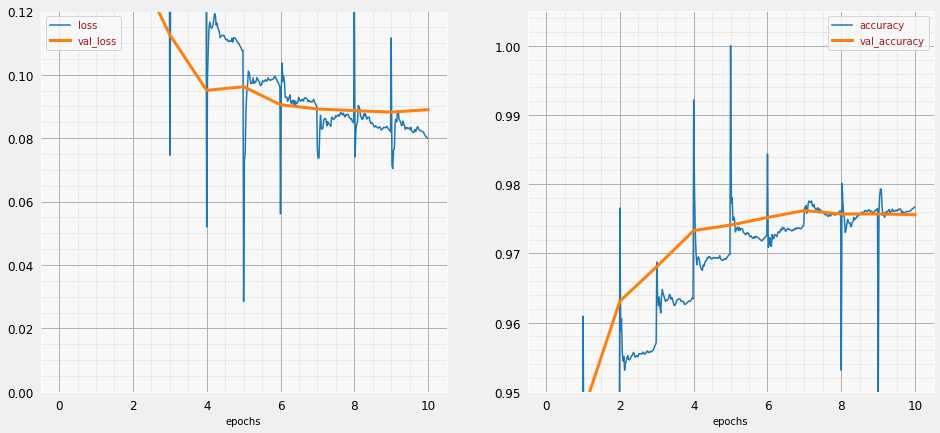

In [36]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training, lr_decay_callback])

The training accuracy is about 97.5% but the training loss is still quite bad.

# **A convolutional network**

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(kernel_size=3, filters=12, activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=6, filters=24, strides=2, activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=6, filters=32, strides=2, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 12)        120       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 24)        10392     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 32)          27680     
_________________________________________________________________
flatten_9 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 200)               57800     
_________________________________________________________________
dense_48 (Dense)             (None, 10)              

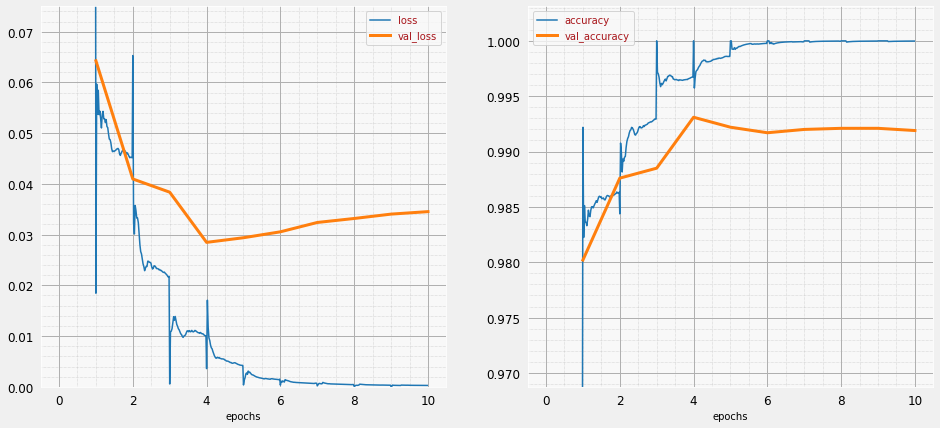

In [40]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training, lr_decay_callback])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


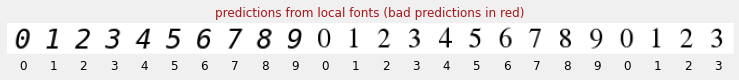

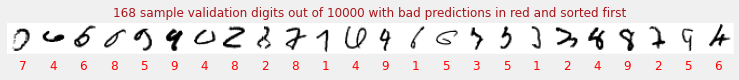

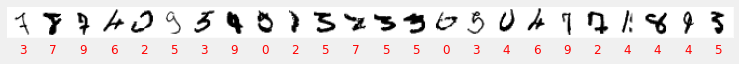

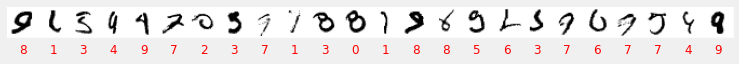

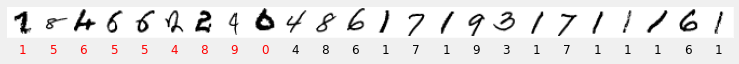

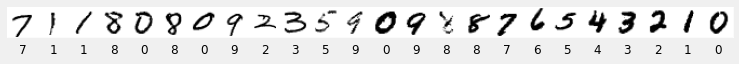

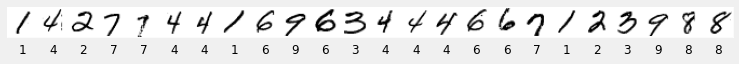

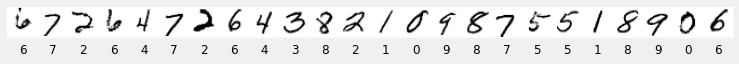

In [41]:
# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

The model's accuracy now went past 99% but the validation loss curve needs to get better. But at this point, many of the validation digits are also classified correctly.

# **Adding dropout again**

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(kernel_size=3, filters=12, activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=6, filters=24, strides=2, activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=6, filters=32, strides=2, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 12)        120       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 24)        10392     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 32)          27680     
_________________________________________________________________
flatten_10 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 200)               57800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)             

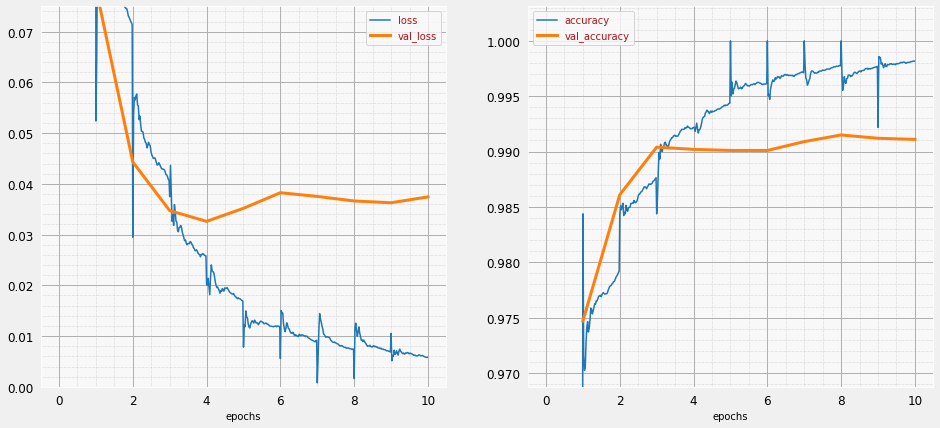

In [43]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training, lr_decay_callback])

The accuracy is being maintained and the validation loss is not going up anymore.

# **Batch Normalization**

In [44]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
      
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, use_bias=False, padding='same'),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(200, use_bias=False),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 12)        36        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 24)        72        
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 24)      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


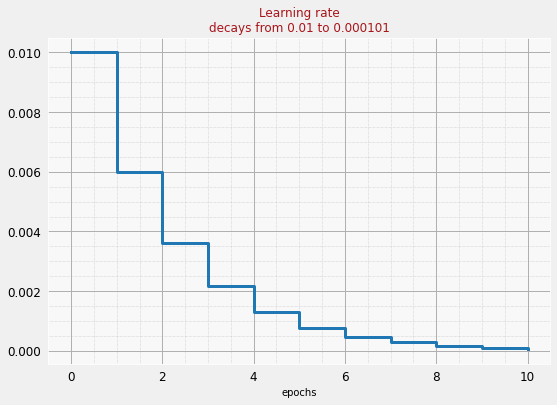

In [45]:
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

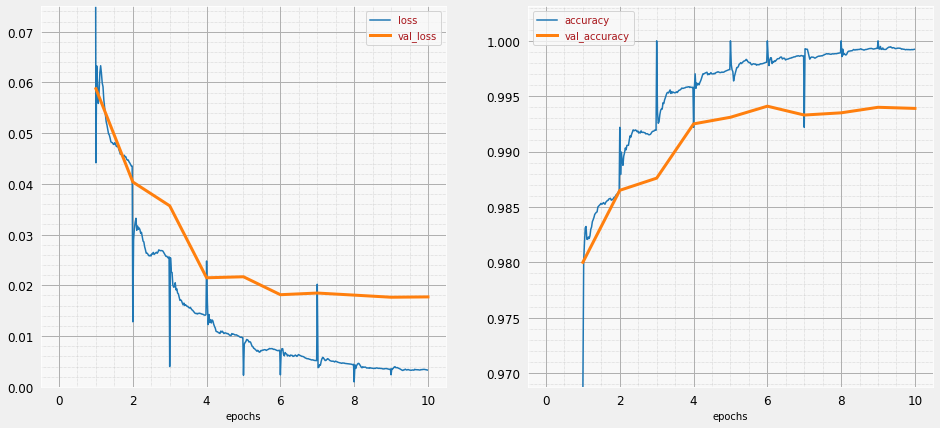

In [46]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training, lr_decay_callback])

The accuracy is now about 99.4% and classifies the validation digits in a much better way.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


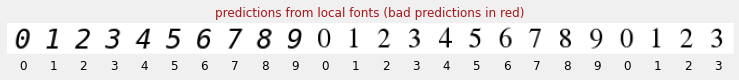

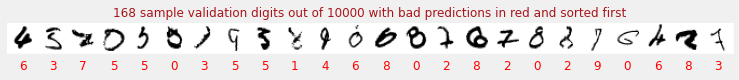

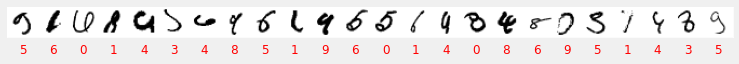

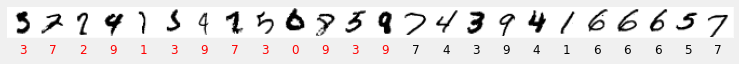

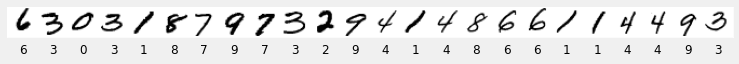

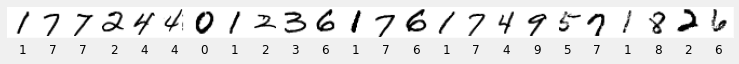

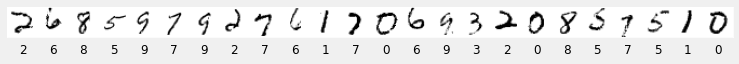

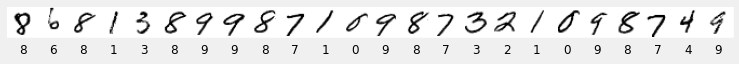

In [47]:
# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)